## 1. Data preprocessing (lab 1)

In [2]:
import pickle
from dataclasses import dataclass
from functools import lru_cache
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from ucimlrepo import fetch_ucirepo


@dataclass
class Data:
    X_train: np.ndarray
    X_test: np.ndarray
    y_train: np.ndarray
    y_test: np.ndarray


@lru_cache
def get_data(offline: bool = False) -> Data:
    """Returns preprocessed (X_train, X_test, y_train, y_test)."""
    if not offline:
        heart_disease = fetch_ucirepo(id=45)
    else:
        pickle_file = Path.cwd().parents[1] / "data" / "heart_disease.pkl"
        with open(pickle_file, 'rb') as picklefile:
            heart_disease = pickle.load(picklefile)

    original_df = heart_disease.data.features
    cat_features = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]
    num_features = ["age", "trestbps", "chol", "thalach", "oldpeak"]

    # Prepare categorical data
    imputer = SimpleImputer(strategy="most_frequent")
    original_df.loc[:, cat_features] = imputer.fit_transform(original_df[cat_features])
    encoder = OneHotEncoder(categories="auto", sparse_output=False)
    encoded_cat_data = encoder.fit_transform(original_df[cat_features])
    encoded_features = encoder.get_feature_names_out(cat_features)
    original_df[encoded_features] = pd.DataFrame(
        encoded_cat_data, columns=encoded_features
    )

    # Prepare numerical data
    scaler = MinMaxScaler()
    scaled_num_data = scaler.fit_transform(original_df[num_features])
    original_df[num_features] = pd.DataFrame(scaled_num_data, columns=num_features)

    # Convert DataFrame to feature matrix
    original_df = original_df.drop(columns=cat_features)
    X = original_df.to_numpy()

    # Prepare binary target data
    y = heart_disease.data.targets.to_numpy()
    y_binary = np.where(y >= 1, 1, 0)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y_binary, test_size=0.2, random_state=42
    )

    return Data(X_train, X_test, y_train, y_test)

### Data type adapter (np.float -> torch.float)

In [3]:
import torch
from torch.utils.data import Dataset


class HeartDiseaseDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)
        self.labels = torch.FloatTensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

## 2. Model (PyTorch)

In [5]:
from dataclasses import dataclass

import torch.nn as nn


@dataclass
class HiddenLayerConfig:
    neurons: int
    f_activ: nn.Module


class HeartDiseaseClassifier(nn.Module):
    """Heart disease classifier that inherits from torch.nn.Module.

    Architecture:
    - Input layer contains `input_features` neurons.
    - N hidden layers, each with `hidden_layers_config[i].neurons` neurons and
        `hidden_layers_config[i].f_activ` activation function.
    - Output layer: 1 neuron with sigmoid activation function.
    """
    def __init__(
        self,
        input_features: int,
        hidden_layers_config: list[HiddenLayerConfig]
    ):
        super().__init__()
        layers = []
        for i in range(len(hidden_layers_config)):
            input_size = input_features if i == 0 else hidden_layers_config[i-1].neurons
            layers.append(nn.Linear(input_size, hidden_layers_config[i].neurons))
            layers.append(hidden_layers_config[i].f_activ)
        layers.append(nn.Linear(hidden_layers_config[-1].neurons, 1))
        layers.append(nn.Sigmoid())
        self.layers = nn.Sequential(*layers)
        # self.layers = nn.Sequential()
        # for i in range(len(hidden_layers_config)):
        #     input_size = input_features if i == 0 else hidden_layers_config[i-1].neurons
        #     self.layers.add_module(
        #         f"linear_{i}",nn.Linear(input_size, hidden_layers_config[i].neurons)
        #     )
        #     self.layers.add_module(f"activation_{i}", hidden_layers_config[i].f_activ)

        # # Output layer
        # self.layers.add_module("output", nn.Linear(hidden_layers_config[-1].neurons, 1))
        # self.layers.add_module("output_activation", nn.Sigmoid())

        # Init weights
        self.layers.apply(self._init_weights)

    def _init_weights(self, module: nn.Module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            nn.init.zeros_(module.bias)

    def forward(self, x):
        return self.layers(x)


### Training

In [6]:
from sklearn.metrics import accuracy_score, f1_score, recall_score
from torch.nn.modules import Module
from torch.optim.optimizer import Optimizer
from torch.utils.data import DataLoader

# from torch.utils.tensorboard import SummaryWriter
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

def train_one_epoch(
    epoch_index: int,
    model: HeartDiseaseClassifier,
    train_loader: DataLoader,
    loss_fn: Module,
    optimizer: Optimizer,
    tb_writer = None
):
    for i, (inputs, labels) in enumerate(train_loader):
        # Zero gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

    return loss


def train_model(
    model: HeartDiseaseClassifier,
    max_epochs: int,
    train_loader: DataLoader,
    val_loader: DataLoader,
    loss_fn: Module,
    optimizer: Optimizer,
    debug: bool = False
    # tb_writer: SummaryWriter = None
):
    results = []
    prev_avg_val_loss = 0.0
    # Initialize training
    for epoch in range(max_epochs):
        model.train()  # Set model to training mode

        # Train for one epoch
        train_one_epoch(
            epoch_index=epoch,
            model=model,
            train_loader=train_loader,
            loss_fn=loss_fn,
            optimizer=optimizer,
        )

        model.eval()
        running_val_loss = 0.0
        all_labels = []
        all_preds = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                val_loss = loss_fn(outputs, labels)
                running_val_loss += val_loss.item()

                # Binary predictions based on threshold 0.5
                binary_preds = (outputs >= 0.5).float()
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(binary_preds.cpu().numpy())

        # Calculate metrics for the epoch
        # val_accuracy = correct_preds / total_preds
        accuracy = accuracy_score(all_labels, all_preds)
        recall = recall_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds)
        avg_val_loss = running_val_loss / len(val_loader)

        results.append({
            "accuracy": accuracy,
            "recall": recall,
            "f1": f1,
            "cost": avg_val_loss
        })

        delta = avg_val_loss - prev_avg_val_loss
        if debug:
            print(f"Epoch [{epoch+1}/{max_epochs}] - avg val loss: {avg_val_loss:.4f} (delta: {delta})")
        prev_avg_val_loss = avg_val_loss

    print("Training complete!")
    return results


### Visualizations

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.axes import Axes


def plot_metrics(results: list[dict[str, float]]):
    x = [i for i in range(len(results))]
    accuracy = [results[i]['accuracy'] for i in x]
    recall = [results[i]['recall'] for i in x]
    f1 = [results[i]['f1'] for i in x]

    plt.figure(figsize=(8, 6))
    plt.plot(x, accuracy, linestyle='-', color='b', label='Accuracy')
    plt.plot(x, recall, linestyle='-', color='r', label='Recall')
    plt.plot(x, f1, linestyle='-', color='g', label='F1 Score')

    plt.xlabel('Epoch')
    plt.ylabel('Metric score')
    plt.title('Plot of metric scores')

    plt.xlim(0, len(results))

    plt.legend()

    plt.grid(True)
    plt.show()


def plot_cost(results: list[dict[str, float]]):
    x = [i for i in range(len(results))]
    cost = [results[i]['cost'] for i in x]

    plt.figure(figsize=(8, 6))
    plt.plot(x, cost, linestyle='-', color='r', label='Cost')

    plt.xlabel('Epoch')
    plt.ylabel('Cost function value')
    plt.title('Plot of cost value over time (epochs)')

    plt.xlim(0, len(results))

    plt.legend()

    plt.grid(True)
    plt.show()


def compare_plots(*results, cost: bool = False):
    cols = min(len(results), 3)
    rows = ((len(results) - 1) // 3) + 1

    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(rows):
        for j in range(cols):
            ax: Axes = axs[i][j] if rows > 1 else axs[j]
            if (3 * i) + j < len(results):
                res = results[(3 * i) + j]
                x = [k for k in range(len(res))]
                if cost:
                    cost = [res[j]['cost'] for j in x]
                    ax.plot(x, cost, linestyle='-', color='r', label='Cost')
                else:
                    accuracy = [res[j]['accuracy'] for j in x]
                    recall = [res[j]['recall'] for j in x]
                    f1 = [res[j]['f1'] for j in x]
                    ax.plot(x, accuracy, linestyle='-', color='b', label='Accuracy')
                    ax.plot(x, recall, linestyle='-', color='r', label='Recall')
                    ax.plot(x, f1, linestyle='-', color='g', label='F1 Score')
                ax.set_xlim(0, len(res))
                ax.legend()
                ax.grid(True)
            else:
                ax.set_visible(False)

    fig.supxlabel('Epoch', fontsize=12)
    if cost:
        fig.supylabel('Cost function value', fontsize=12)
        fig.suptitle('Plot of cost value over time (epochs)', fontsize=14)
    else:
        fig.supylabel('Metric scores', fontsize=12)
        fig.suptitle('Plot of metric scores over time (epochs)', fontsize=14)

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

## 3. Base model (starting point)

Training complete!


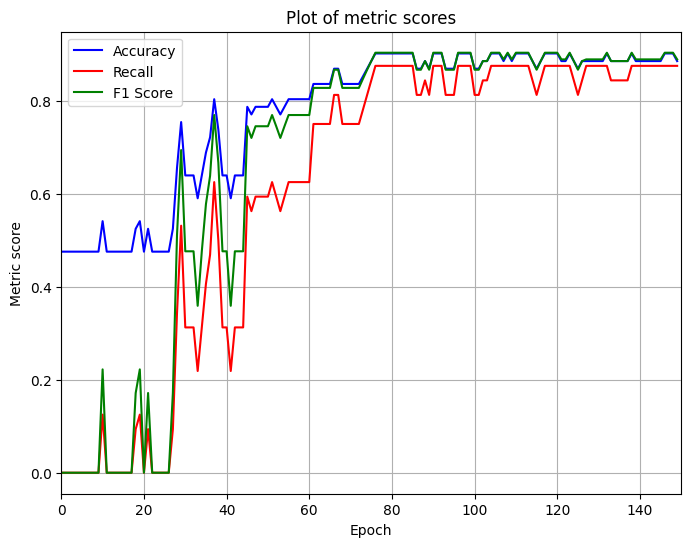

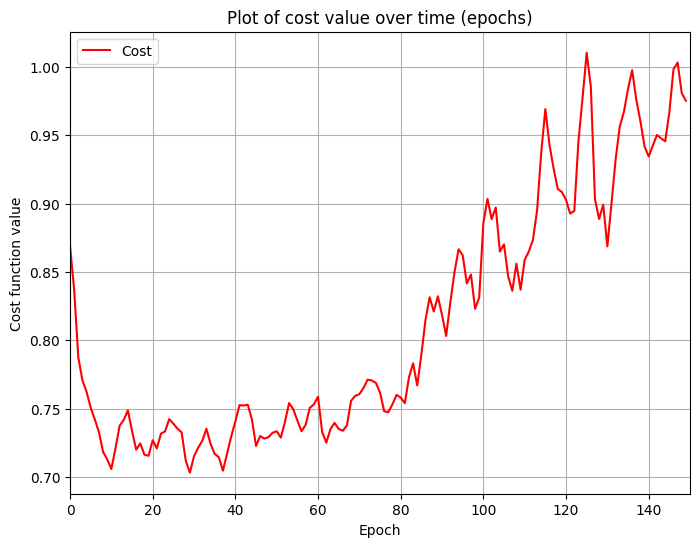

In [8]:
import torch.nn as nn

BATCH_SIZE = 30

data = get_data(offline=True)

train_dataset = HeartDiseaseDataset(data.X_train, data.y_train)
val_dataset = HeartDiseaseDataset(data.X_test, data.y_test)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

model = HeartDiseaseClassifier(
    input_features=data.X_train.shape[1],
    hidden_layers_config=[
        HiddenLayerConfig(14, nn.Sigmoid()),
        HiddenLayerConfig(7, nn.Sigmoid())
    ]
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.0065, momentum=0.9)

results = train_model(
    model=model,
    max_epochs=150,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=nn.BCELoss(),
    optimizer=optimizer,
    # tb_writer: SummaryWriter = None
)

plot_metrics(results)
plot_cost(results)

### Note

Experiment presented above confirms the thesis stated on the last lab - network with 2 hidden layers is overcomplicated for this particular binary classification. Even with carefully selected hiperparameters (size of each layer, learning rate) we can see that model barely can reach the expected metric scores and when it eventually does - overfitting is already present. That's why in the following experiments we will stick to the network with just a single hidden layer (of size ~12 neurons) and learning rate ~0.0013. The following charts present performance of a network with such hiperparameters, which is actually really good: metric scores reach almost 0.85 while cost oscillates between 0.68-0.72 and doesn't show significant overfitting symptoms.

Training complete!


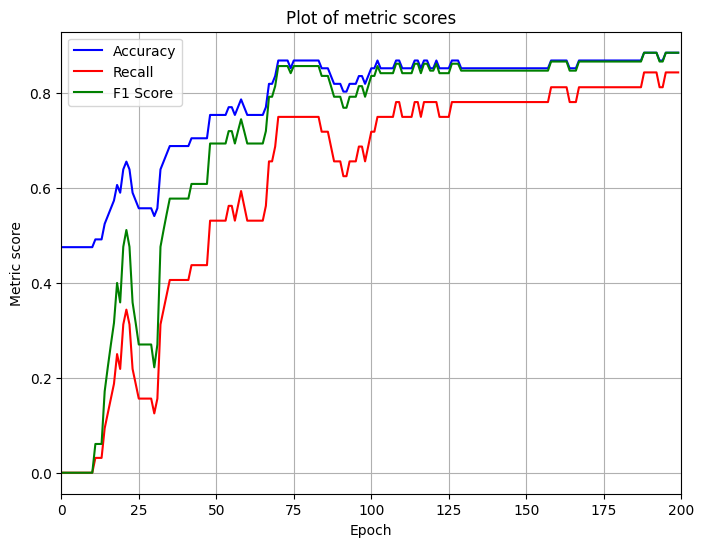

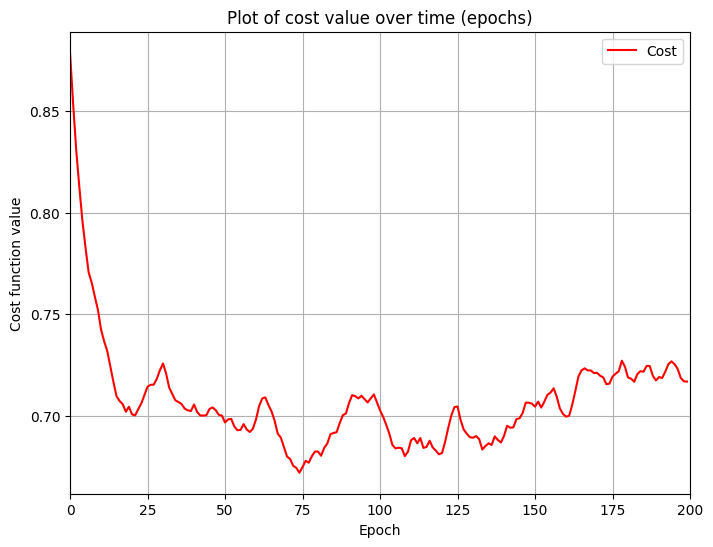

In [9]:
import torch.nn as nn

BATCH_SIZE = 30

data = get_data(offline=True)

train_dataset = HeartDiseaseDataset(data.X_train, data.y_train)
val_dataset = HeartDiseaseDataset(data.X_test, data.y_test)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

model = HeartDiseaseClassifier(
    input_features=data.X_train.shape[1],
    hidden_layers_config=[
        HiddenLayerConfig(12, nn.Sigmoid())
    ]
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.0013, momentum=0.9)

results = train_model(
    model=model,
    max_epochs=200,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=nn.BCELoss(),
    optimizer=optimizer,
    # tb_writer: SummaryWriter = None
)

plot_metrics(results)
plot_cost(results)

## 4. Experiments

### 1. Optimizer (SGD vs ... vs ...)

In [26]:
import torch.nn as nn

BATCH_SIZE = 30

data = get_data(offline=True)

train_dataset = HeartDiseaseDataset(data.X_train, data.y_train)
val_dataset = HeartDiseaseDataset(data.X_test, data.y_test)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

model = HeartDiseaseClassifier(
    input_features=data.X_train.shape[1],
    hidden_layers_config=[
        HiddenLayerConfig(12, nn.Sigmoid())
    ]
)

optimizer_sgd = torch.optim.SGD(model.parameters(), lr=0.0013, momentum=0.9)
optimizer_adam = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999))
optimizer_adamw = torch.optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=0.001)

results_sgd = train_model(
    model=model,
    max_epochs=200,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=nn.BCELoss(),
    optimizer=optimizer_sgd,
)

results_adam = train_model(
    model=model,
    max_epochs=200,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=nn.BCELoss(),
    optimizer=optimizer_adam,
)

results_adamw = train_model(
    model=model,
    max_epochs=200,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=nn.BCELoss(),
    optimizer=optimizer_adamw,
)

Training complete!
Training complete!
Training complete!


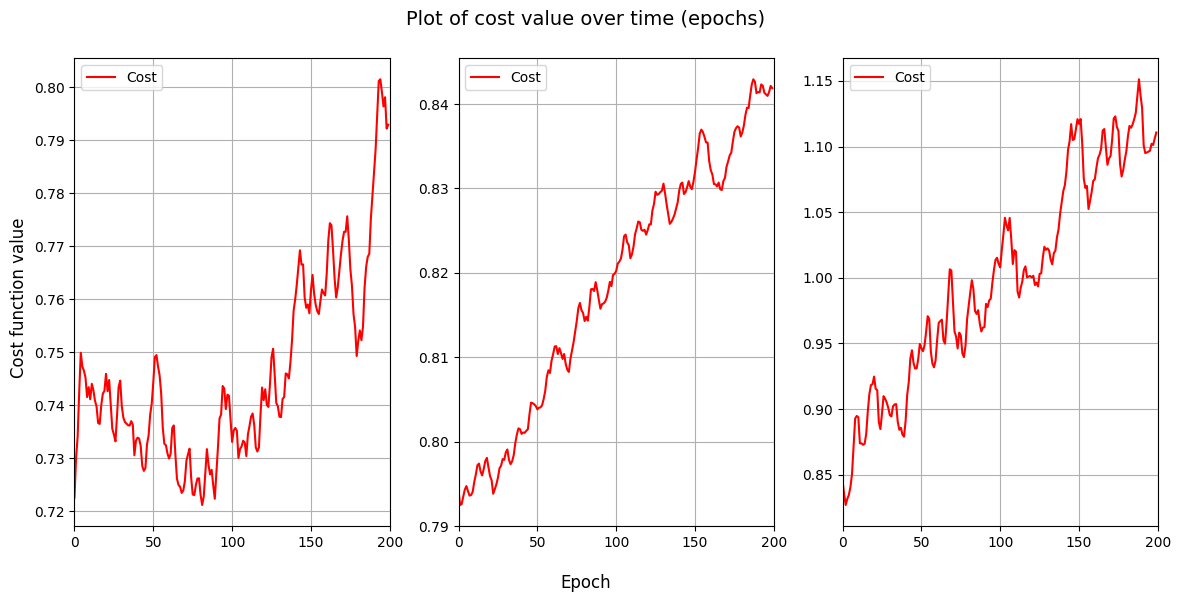

In [28]:
compare_plots(results_sgd, results_adam, results_adamw, cost=True)